my attempt at running a neural network for image classification
- borrowed from Brian's code as well as this tutorial: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [ ]:
# Import required packages
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torchvision
from torchvision import transforms
import torchvision.models as models

import tqdm

import sys
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
print(os.getcwd())
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
print(device)

In [3]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'C:/Users/nour/Downloads/train_data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('C:/Users/nour/Downloads/train_data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('C:/Users/nour/Downloads/train_data/noisy_labels.csv', delimiter=',', dtype="int8")

In [4]:
# Split clean labels into training set and validation set

X_train_clean_noisy, X_test_clean_noisy, y_train, y_test = train_test_split(imgs[:n_clean_noisy], np.column_stack((clean_labels, noisy_labels[:10000])), test_size=0.25,random_state=5243)
y_train_clean = y_train[:,0]
y_train_noisy = y_train[:,1]
y_test_clean = y_test[:,0]
y_test_noisy = y_test[:,1]
if not os.path.exists("../data/test_labels.csv"):
    np.savetxt("../data/test_labels.csv", y_test_clean, delimiter=",")
if not os.path.exists("../data/test_images"):
    os.mkdir("../data/test_images")
    for i in range(X_test_clean_noisy.shape[0]):
        img_fn = f'../data/test_images/test{i+1:05d}.png'
        cv2.imwrite(img_fn,cv2.cvtColor(X_test_clean_noisy[i].astype('float32'), cv2.COLOR_RGB2BGR))
X_train = np.concatenate((X_train_clean_noisy,imgs[10000:]))
y_train_total_noisy = np.concatenate((y_train_noisy,noisy_labels[10000:]))

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [14]:
class Dataset(Dataset):
    def __init__(self, X_train, Y_train, transform=None):
        self.X = X_train
        self.y = Y_train
        self.transform = transform

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        x = self.X[idx]
        if self.transform:
            x = self.transform(x.astype(np.uint8))   
        else:
            x = np.transpose(x,(2,0,1))
        return x, self.y[idx]

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


dataset = Dataset(X_train,y_train_total_noisy,transform=transform)

In [18]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

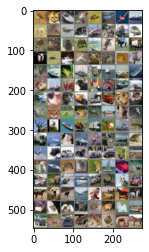

bird  cat   ship  truck bird  bird  plane deer  dog   deer  deer  cat   frog  bird  ship  frog  plane truck bird  cat   ship  cat   cat   truck dog   deer  plane truck frog  frog  frog  bird  horse horse frog  ship  frog  ship  plane bird  cat   cat   deer  ship  frog  car   deer  deer  car   dog   deer  bird  car   cat   bird  car   frog  cat   truck bird  truck ship  truck car   deer  plane plane bird  truck horse truck frog  plane plane horse car   plane deer  plane frog  car   bird  car   cat   car   dog   bird  cat   ship  ship  cat   cat   cat   car   cat   deer  dog   deer  car   truck frog  deer  horse truck frog  dog   horse ship  car   bird  horse horse deer  car   dog   horse bird  cat   deer  frog  car   deer  car   car   frog  bird  bird  deer 


In [24]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(128)))

In [29]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [30]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [31]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

RuntimeError: expected scalar type Long but found Char